In [2]:
# %load ../config.py
import glob
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
import tensorflow as tf
import tensorflow_datasets as tfds
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from keras import layers
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

K = keras.backend
AUTOTUNE = tf.data.AUTOTUNE

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Plots colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"

# Data Frame color theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FFFCFA",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #4A4B52; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)

HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
    counter-reset: item;
    }
    ol.numbered-list li {
    display: block;
    }
    ol.numbered-list li:before {
    content: counters(item, '.') '. ';
    counter-increment: item;
    }
    </style>
"""

# Utility functions.
def download_from_kaggle(expr, directory=None, /) -> None:
    if directory is None:
        directory = Path("data")
    if not isinstance(directory, Path):
        raise TypeError("The `directory` argument must be `Path` instance!")
    match expr:
        case ["kaggle", _, "download", *args] if args:
            directory.parent.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (directory / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, directory)
                shutil.move(filename, directory)
        case _:
            raise SyntaxError("Invalid expression!")


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)


In [3]:
dataset = "tyre-quality-classification"
user = "warcoder"
expr = f"kaggle datasets download -d {user}/{dataset}".split()

download_from_kaggle(expr)


In [14]:
dataset_path = Path("data/Digital images of defective and good condition tyres")
dataset_path

WindowsPath('data/Digital images of defective and good condition tyres')

In [49]:
train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=("defective", "good"),
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation="nearest",
    crop_to_aspect_ratio=True,
)
valid_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=("defective", "good"),
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="nearest",
    crop_to_aspect_ratio=True,
)


Found 1856 files belonging to 2 classes.
Using 1485 files for training.
Found 1856 files belonging to 2 classes.
Using 371 files for validation.


In [47]:
train_ds = train_ds.cache().batch(32, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [50]:
bench_results = tfds.benchmark(train_ds, batch_size=32)


************ Summary ************



  0%|          | 0/47 [00:00<?, ?it/s]

Examples/sec (First included) 136.67 ex/sec (total: 1536 ex, 11.24 sec)
Examples/sec (First only) 14.34 ex/sec (total: 32 ex, 2.23 sec)
Examples/sec (First excluded) 166.97 ex/sec (total: 1504 ex, 9.01 sec)


In [272]:
from tensorflow.train import BytesList, FloatList, Int64List  # type: ignore
from tensorflow.train import Feature, Features, Example  # type: ignore


In [301]:
def serialize_images_to_tfrecord(image_paths, labels, filename, /, compression=None):
    options = tf.io.TFRecordOptions(compression_type=compression)
    resizing = layers.Resizing(height=256, width=256, crop_to_aspect_ratio=True)

    with tf.io.TFRecordWriter(filename, options) as f:
        for image_path, label in zip(image_paths, labels):
            image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
            image_resized = tf.cast(resizing(image), dtype=tf.uint8)
            image_encoded = tf.io.encode_jpeg(image_resized)
            example = Example(
                features=Features(
                    feature={
                        "image": Feature(bytes_list=BytesList(value=[image_encoded.numpy()])),
                        "label": Feature(int64_list=Int64List(value=[label])),
                    }
                )
            )
            f.write(example.SerializeToString())


In [302]:
def get_train_valid_subsets(data_path, /, valid_ratio=0.2, seed=None):
    defective_paths = glob.glob(str(data_path / "defective/*"))
    good_paths = glob.glob(str(data_path / "good/*"))
    paths = np.concatenate((defective_paths, good_paths))

    defective_labels = [0] * len(defective_paths)
    good_labels = [1] * len(good_paths)
    labels = np.concatenate((defective_labels, good_labels))

    return train_test_split(
        paths, labels, test_size=valid_ratio, random_state=seed, stratify=labels
    )


In [303]:
data_path = Path("data/Digital images of defective and good condition tyres")
train_paths, valid_paths, train_labels, valid_labels = get_train_valid_subsets(
    data_path, valid_ratio=0.2, seed=42
)


In [304]:
serialize_images_to_tfrecord(train_paths, train_labels, "train.tfrecord", compression="GZIP")
serialize_images_to_tfrecord(valid_paths, valid_labels, "valid.tfrecord", compression="GZIP")


tf.Tensor(0, shape=(), dtype=int64) (256, 256, 3)


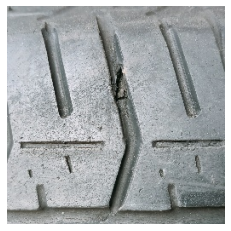

In [292]:
for image, label in dataset.take(1):
    #print(image[0], label[0])
    print(label[0], image[0].shape)
    plt.imshow(image[0])
    plt.axis("off")
    plt.show()

In [342]:
FEATURE_DESCR = {
    "image": tf.io.VarLenFeature(tf.string),
    "label": tf.io.FixedLenFeature([1], tf.int64),
}


def parse_example(serialized_example, /):
    example = tf.io.parse_single_example(serialized_example, FEATURE_DESCR)
    return tf.io.decode_jpeg(example["image"].values[0], channels=3), example["label"][0]


def augmentation(X):
    random_augment = keras.Sequential(
        [
            # Subjective factors.
            layers.RandomRotation(0.1, fill_mode="nearest"),
            layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        ]
    )
    return random_augment(X)


def get_dataset_from_tfrecord(
    filename,
    compression,
    /,
    batch_size=32,
    augment=False,
    cache=True,
    shuffle=False,
    shuffle_buffer_size=256,
    seed=None,
):
    dataset = tf.data.TFRecordDataset(filename, compression_type=compression)
    dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    if augment:
        dataset = dataset.map(lambda X, y: (augmentation(X), y), num_parallel_calls=AUTOTUNE)
    scaling = layers.Rescaling(scale=1 / 255.0)
    dataset = dataset.map(lambda X, y: (scaling(X), y), num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)


In [349]:
train_ds = get_dataset_from_tfrecord("train.tfrecord", "GZIP", augment=False, shuffle=True, seed=42)


In [335]:
dataset = tf.data.TFRecordDataset("train.tfrecord", "GZIP")
dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)

In [353]:
tfds.benchmark(train_ds, batch_size=32)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 3010.89 ex/sec (total: 1536 ex, 0.51 sec)
Examples/sec (First only) 290.40 ex/sec (total: 32 ex, 0.11 sec)
Examples/sec (First excluded) 3760.42 ex/sec (total: 1504 ex, 0.40 sec)


,duration,num_examples,avg
first+lasts,0.510147,1536,3010.893908
first,0.110192,32,290.401153
lasts,0.399955,1504,3760.422107


In [320]:
for item in dataset.take(1):
    print(item)

(<tf.Tensor: shape=(256, 256, 3), dtype=uint8, numpy=
array([[[118, 121, 114],
        [128, 131, 124],
        [120, 123, 116],
        ...,
        [130, 130, 122],
        [ 96,  97,  91],
        [ 92,  93,  87]],

       [[111, 114, 107],
        [120, 123, 116],
        [114, 117, 110],
        ...,
        [113, 113, 105],
        [159, 159, 151],
        [ 97,  98,  90]],

       [[125, 128, 121],
        [124, 127, 120],
        [109, 112, 105],
        ...,
        [104, 101,  92],
        [112, 109, 100],
        [172, 172, 162]],

       ...,

       [[144, 142, 129],
        [157, 155, 142],
        [190, 191, 177],
        ...,
        [ 63,  65,  60],
        [ 68,  70,  65],
        [ 67,  69,  64]],

       [[216, 214, 199],
        [206, 204, 189],
        [186, 187, 173],
        ...,
        [ 65,  67,  62],
        [ 64,  69,  63],
        [ 63,  68,  62]],

       [[190, 189, 171],
        [162, 160, 145],
        [191, 192, 178],
        ...,
        [ 97,  99,  